In [1]:
# box cox transform
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

The data, descriptions of the variables and some examples can be found here:
[house-pricese-from-kaggle-competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [2]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


In [4]:
train = pd.read_csv('../data/train.csv', sep=",")
test = pd.read_csv('../data/test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)

data = pd.concat((train, test))
data.reset_index(drop = True, inplace = True)
# categorical and numericalvariables:

categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

In [5]:
data[categorical] = data[categorical].fillna('None')


## next, we substitute missing values with the mean of the variable and form new variables
## indicating the missing values. Sometimes data is not missing at random and the fact that
## data is missing might contain valuable information
variables_na = []
for val in numerical:
    data[val + '_na'] = pd.isnull(data[val])
    variables_na.append(val + '_na')
    data[val].fillna(data[val].mean(), inplace = True)


[box-cox transform in short](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)

In [6]:
## box-cox transform is variance stabilizing. It is meant to make 
## the variable more normaly distributed    
box_cox = []
for val in numerical:
    new_vals, lamb = boxcox(data[val] + 1)
    if np.abs(lamb) < 8:
        data[val + '_box_cox'] = new_vals
        box_cox.append(val)

        

/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


In [7]:
from sklearn.preprocessing import OneHotEncoder
# as already announced, categorical data is one-hot encoded (dummy-coded)  

data_base = pd.get_dummies(data[[col for col in data.columns if col not in variables_na]])
data_na = pd.get_dummies(data[variables_na])

# we have to cast every variable's data type to float32 for our next 'trick' 
data_base = data_base.astype(np.float32)
data_na = data_na.astype(np.float32)
data_numerical = data[numerical]

data = pd.concat([data_base, data_na], axis = 1)

In [9]:
# the number of variables is quiet high. We want to add interaction terms for the most important
# variables. Therefore, we want to compute some variable-importance measure. This is
# done by the help of gradient boosted trees:
gbm = GradientBoostingRegressor(n_estimators = 32, max_depth = 4)
gbm.fit(data.iloc[0:len(train_ID)].values, SalePrice.values)

GradientBoostingRegressor(max_depth=4, n_estimators=32)

In [10]:
from sklearn.inspection import permutation_importance

# we sort the variables (indizes) by variable importance
indizes = np.argsort(gbm.feature_importances_)
result = permutation_importance(gbm, data.iloc[0:len(train_ID)], SalePrice, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [35]:
type(sorted_idx)

numpy.ndarray

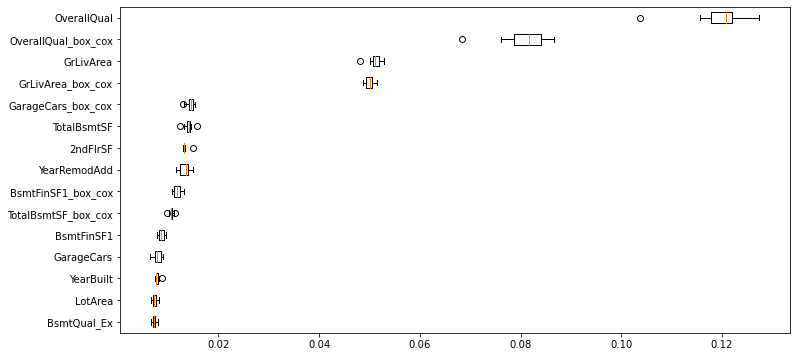

In [12]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx[-15:]].T,
            vert=False, labels=np.array(data.columns)[sorted_idx[-15:]])
fig.show()

In [13]:
# import a tool for getting all possible n over 2 combinations of these variables
from itertools import combinations
# and add the interactions
interactions = []
for comb in list(combinations(data.columns[sorted_idx[-15:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions.append(comb[0] + '_x_' + comb[1])

data_interactions = data[interactions]


## 1.
# now, we have different data sets
# the base set with missing values imputed by the mean and no other feature engineering
# box-cox transformed variables are removen
base = data_base[[col for col in data_base.columns if not col.endswith('_box_cox')]]
## 2.
# box_cox is admitted; original variables removed
with_box_cox = data_base[[col for col in data_base.columns if not col in box_cox]]
## 3.
# variables indicating formerly missing values are included
with_na = pd.concat([with_box_cox, data_na], axis = 1)
## 4.
# all interaction terms of the 55 most important variables are added
with_interactions = pd.concat([with_na, data_interactions], axis = 1)

## the target variable is log-transformed
y = np.log1p(SalePrice)

## since we want to try elasticnet, we have to find the optimal parameter for 
# lambda (amount of regularization) and for alpha (ratio of lasso and ridge mixing)
lamb = 10**(np.linspace(-1, 0.2, 15))
# ratio
ratio = np.linspace(0, 1, 10)

In [14]:
error = []
best_parameters = []
# we iterate over list of data-sets
for d in [base, with_box_cox, with_na, with_interactions]:
    # scale variables
    scaler = StandardScaler()
    scaler.fit(d[:len(train_ID)]) #  fit  the scale        

    X_train = scaler.transform(d[:len(train_ID)])
    X_test = scaler.transform(d[len(train_ID):])
    
    # the function cross_val_score computes the model passed to it for cv=5-fold 
    # cross validation; we compute the mean over the 5 folds
    get_results = [(l, r, np.mean(np.sqrt(-cross_val_score(ElasticNet(alpha = l,
                                                            l1_ratio = r),
            X_train, y , scoring = 'neg_mean_squared_error',
            cv = 5, n_jobs = -1))))
                for l in lamb for r in ratio]
    
    # the least error is extracted
    least_error = np.min([i[2] for i in get_results])
    error.append(least_error)
    # the parameters belonging to the best result
    parameters = [i[0:2] for i in get_results if i[2] == least_error]
    best_parameters.append(parameters)
    print(f'least error is: {least_error}, best parameters are: {parameters}')


least error is: 0.1382281067080659, best parameters are: [(0.3981071705534972, 0.0)]
least error is: 0.13065758654150422, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.13065758650403755, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.12747436329217848, best parameters are: [(0.14839817889675655, 0.0)]


In [15]:
best_parameters

[[(0.3981071705534972, 0.0)],
 [(0.1, 0.1111111111111111)],
 [(0.1, 0.1111111111111111)],
 [(0.14839817889675655, 0.0)]]

In [22]:
display(base.shape, with_box_cox.shape, with_na.shape, with_interactions.shape)

(2919, 310)

(2919, 310)

(2919, 346)

(2919, 451)

We conclude:
1. The error for the base data set (only missing values imputed) is: {{np.round(error[0], 4)}}  (mse); The corresponding lambda is {{np.round(best_parameters[0][0][0], 4)}}, i.e. the amount of regularization; the l1_ratio = {{np.round(best_parameters[0][0][1], 4)}}; the kind of regularization was pure ridge (l2-penalty)
2. The error with some of the numeric variables box-cox transformed is {{np.round(error[1], 4)}} (mse); the amount of regularization is far less than before ({{np.round(best_parameters[1][0][0], 4)}}); we have {{np.round(best_parameters[1][0][1] * 100)}}% l1-penalty and {{np.round(100 - (best_parameters[1][0][1] * 100))}}% l2-penalty
3. Indicator variables for formerly missing values are included in the data-set; The error ({{np.round(error[2], 4)}}) shrinks by an insignificant amount. The lambda parameter is {{np.round(best_parameters[2][0][0], 4)}}; no l1-penalty is used
4. adding the interaction terms has the most pronounced effect. The error drops to {{np.round(error[3], 4)}}; The best parameters are as before.

One additional note: By including the interaction terms, we have __more variables (1831) than observations (1460)__ in the training set. This situation is not admissable in classical statistics. For machine learning algorithms with regularization, it does not mean any problem.

We now have found the best parameters by cross-validation. Now, we try to solve a business problem with these results:<br>
__The sales team needs all houses from the test set with estimated prices higher than 350'000\$. Can you please deliver an estimate about how accurate your predictions are?__<br>
1. Compute the confidence intervals for the test-set.
We proceed as follows:
2. Obtain estimates for the train-set by splitting the train-set in k=5 folds and always train on 4 folds and make predictions on the 5th fold. We obtain CIs in this manner.
3. We take the lower-bounds of the confidence intervals. This ensures, that we do not include cases (houses) with very unstable estimates.
4. Since we trained the CIs for the training-set with cross-validation, we can treat them as an estimate for the accuracy of the CIs of the test-set: This gives us an estimate of the error we make.

In [23]:
import warnings
from random import choices
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold # import KFold
warnings.filterwarnings('ignore')
# we get a lot of warnings:
# LinAlgWarning: Ill-conditioned matrix (rcond=1.80167e-08): result may not be accurate.
#  overwrite_a=False)
# this is because we use more variables than observations and we get the already discussed
# problems with matrix inversion


scaler = StandardScaler()
scaler.fit(with_interactions) #  fit  the scale        


X = scaler.transform(with_interactions[:len(train_ID)])
test = scaler.transform(with_interactions[len(train_ID):])

## 1.
indices = np.arange(0, X.shape[0])
# draw 200 samples with replacement from training data set
sampler = (choices(indices, k = len(indices)) for i in range(200))
# fit 200 models to the samples drawn and predict on test-set
# 
CIS_test = np.percentile(
            np.array(
                [
                 Ridge(alpha=best_parameters[-1][0][0], fit_intercept=True)\
                 .fit(X[drew,:], y.values[drew]).predict(test).tolist()
                 for drew in sampler]
                 ), [2.5, 97.5], axis = 0)


## 2.
kf = KFold(n_splits = 5, shuffle=True)
CIS = np.empty((2, X.shape[0]))
y_hat = np.empty((y.shape[0],))
for train_index, test_index in kf.split(X):
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    indices = np.arange(0, X_train.shape[0])

    sampler = (choices(indices, k = len(indices)) for i in range(200))
    CIS[:, test_index] = np.percentile(
        np.array(
            [
             Ridge(alpha=best_parameters[-1][0][0], fit_intercept=True)\
             .fit(X_train[drew,:], y_train.values[drew])\
                              .predict(X_test).tolist()
             for drew in sampler]
             ), [2.5, 97.5], axis = 0)


In [24]:
## 3.
bool_indizes = np.exp(CIS_test[0, :]) + 1 > 350000
sum(bool_indizes)
for_sales_departement = list(
    zip(np.arange(0, CIS_test.shape[1])[bool_indizes], np.exp(CIS_test[0, bool_indizes])+1)
)


In [25]:
y_hat_lower = np.exp(CIS[0,:])+1
estimates = y_hat_lower > 350000
true = (np.exp(y) +1) > 350000
y_hat_lower[estimates]
print(f'we estimate that {np.round(np.mean(true[estimates]) * 100, 2)}% of our predictions are correct')
print(f'\nhowever, we only got {np.round(sum(estimates)/sum(true)*100, 2)}% of all houses with prices higher than 350000')


we estimate that 95.24% of our predictions are correct

however, we only got 37.5% of all houses with prices higher than 350000


## Now, suppose
the sales team wants to use your algorith for new incoming houses. How good can we predict theses houses?

__Exercise:__ get the estimates right by help of python Pipelines

In [30]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


One-hot encoding and adding variables for missing values is not critical: no statistics are fitted<br>

we load the data (only train) once again:

In [39]:
train = pd.read_csv('../data/train.csv', sep=",")
train_ID = train['Id']
train.drop('Id', axis = 1, inplace = True)
SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

Next we add an indicator variable for every missing value: no statistics are fitted:

In [40]:
train[categorical] = train[categorical].fillna('None')
for val in numerical:
    train[val + '_na'] = pd.isnull(train[val])

what however depends on the data - statistcs are fitted is:<br>
- filling NAs with mean-values
- box-cox transform of variable
- computing the best features and forming interaction variables
- fitting the model

In [79]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from interactions_transformer import InteractionsTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

numeric_features = numerical
categorical_features = categorical

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

clf = GridSearchCV(
        make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet()
            ),
            param_grid={'elasticnet__alpha': 10**(np.linspace(-1, 0.2, 5)),
                        'elasticnet__l1_ratio': np.linspace(0, 1, 6)},
         cv=5, refit=True, scoring = 'neg_mean_squared_error'
)


In [ ]:
train[numerical] += 1
clf.fit(train, np.log1p(SalePrice))

In [76]:
y.values

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [61]:
display(clf.best_params_, np.sqrt(-clf.best_score_))
# clf.cv_results_.keys()

{'elasticnet__alpha': 0.14839817889675655,
 'elasticnet__l1_ratio': 0.8888888888888888}

31387.974830628635

we hope that {{a}} will render